## Finds Black Box artifacts across all Z, per channel, record coverage and create masks

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import numpy as np
import os
import sys
import glob
from imageio import volread as imread

from skimage.segmentation import expand_labels
import tifffile


In [2]:
os.getcwd()

'/mnt/disks/store'

/mnt/disks/store/101222_D10_Coverslip1_Processed


,channel_number,cycle_number,marker_name,Filter,excitation_wavelength,emission_wavelength,Bandwidth,ch_index,Split_Num
0,1,0,DNA_0,DAPI,405,445,46,0,0
1,2,0,Blank_488_0,GFP,488,521,38,1,1
2,3,0,Blank_561_0,RFP,561,594,43,2,2
3,4,0,Blank_637_0,Cy5,637,698,77,3,3
4,5,1,DNA_1,DAPI,405,445,46,0,4


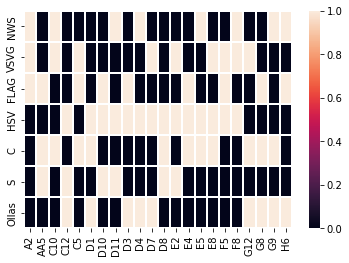

In [3]:
# define inputs
##########################################################################################
IN_DIR = 'merged'
OUT_DIR = 'mask'
META_DIR = 'metadata'
# define input directory
DATA_DIR = '101222_D10_Coverslip1_Processed'
##########################################################################################
os.chdir(f'{DATA_DIR}')
print(os.getcwd())

SOURCE = f'gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/{DATA_DIR}/'

# load metadata - load full codebook as well
full_codebook = pd.read_csv(f'../{META_DIR}/full_codebook.csv',sep=',', index_col=0) # this is "legal" codebook
Procode_gRNA = pd.read_csv(f'../{META_DIR}/PROCODE_gRNA.csv',sep=',')
legal_codes = sorted(list(set(Procode_gRNA['ProCode ID'].to_list())))
codebook = full_codebook[legal_codes]
#AllProcodes = pd.read_csv('AllProcodes.csv', sep='.')
sns.heatmap(codebook, linewidths = 0.3)
markers = pd.read_csv(f'../{META_DIR}/markers.csv')
markers.head()

In [4]:
# get indices of final channels --> only make mask when happening in these indices of merged file
final_inds = []
marker_names = ['DNA_0','NWS','VSVG','FLAG','HSV','C','S','Ollas','GFAP','NeuN',
               'pRPS6','RANGAP1','NFKB','TOM20','LAMP1','4HNE','TDP43','G3BP1','GM130','Calnexin','Golgin97',
               'SYTO','ER','AGP','Catalase']

for marker in marker_names:
    ind_to_add = markers[markers.marker_name == marker]['Split_Num'].values[0]
    final_inds.append(ind_to_add)
final_inds

[0,
 5,
 6,
 7,
 9,
 10,
 11,
 13,
 14,
 15,
 17,
 18,
 19,
 21,
 22,
 23,
 25,
 27,
 29,
 30,
 31,
 33,
 35,
 36,
 37]

In [5]:
# copy over reg_bin to get FOV numbers --> this is the smallest file size 
cmd = 'gsutil -m rsync -r ' + SOURCE + 'reg_bin_Cyc_2 ' + 'reg_bin_Cyc_2'
! {cmd}

Building synchronization state...
Starting synchronization...


In [6]:
_allFOVs = sorted(glob.glob('reg_bin_Cyc_2/*'))
allFOVs = [x.split('F')[-1][:3] for x in _allFOVs]
print(allFOVs)
print(len(allFOVs))

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142'

In [7]:
for ii in range(0,len(allFOVs),10): # For each CHUNK (10 FOVs per loop)
    print(allFOVs[ii:ii+10])

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']
['010', '011', '012', '013', '014', '015', '016', '017', '018', '019']
['020', '021', '022', '023', '024', '025', '026', '027', '028', '029']
['030', '031', '032', '033', '034', '035', '036', '037', '038', '039']
['040', '041', '042', '043', '044', '045', '046', '047', '048', '049']
['050', '051', '052', '053', '054', '055', '056', '057', '058', '059']
['060', '061', '062', '063', '064', '065', '066', '067', '068', '069']
['070', '071', '072', '073', '074', '075', '076', '077', '078', '079']
['080', '081', '082', '083', '084', '085', '086', '087', '088', '089']
['090', '091', '092', '093', '094', '095', '096', '097', '098', '099']
['100', '101', '102', '103', '104', '105', '106', '107', '108', '109']
['110', '111', '112', '113', '114', '115', '116', '117', '118', '119']
['120', '121', '122', '123', '124', '125', '126', '127', '128', '129']
['130', '131', '132', '133', '134', '135', '136', '137', '138', '139']
['140'

In [8]:
# record in dataframe
count0_df = pd.DataFrame(index=allFOVs, columns = list(range(38)))
count20_df = pd.DataFrame(index=allFOVs, columns = list(range(38)))
count65K_df = pd.DataFrame(index=allFOVs, columns = list(range(38)))
count65K_df

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
from skimage.segmentation import *
from skimage import measure

In [ ]:
for ii in range(0,len(allFOVs),10): # For each CHUNK (10 FOVs per loop)
    print(allFOVs[ii:ii+10])
     # download chunk
    for fov in allFOVs[ii:ii+10]: # for each fov in CHUNK
        cmd = 'gsutil cp ' + SOURCE + IN_DIR + f'/F{fov}.tif {IN_DIR}'
        print(cmd)
        ! {cmd}
        print("download complete for this chunk")
        img = imread(f'{IN_DIR}/F{fov}.tif') # load input image
        print(img.shape)
        
        img = img.transpose(1,0,2,3) 
        # C Z Y X format. you may use image as it is but should change bottom line to axis=(0,2,3)
        count0 = np.count_nonzero(img==0, axis=(1,2,3))
        count20 = np.count_nonzero(img<20, axis=(1,2,3))
        count65K = np.count_nonzero(img>65000, axis=(1,2,3))
        
        # initialize mask, save_im_flag
        save_im_flag = False
        mask = np.zeros(img[0,0,...].shape)
        print("mask shape", mask.shape)
        mask = mask.astype('bool')
        # check for each channel;
        for ch in range(count0.shape[0]):
            # record in dataframe
            count0_df.loc[fov, ch] = count0[ch]
            count20_df.loc[fov, ch] = count20[ch]
            count65K_df.loc[fov, ch] = count65K[ch]
            if ch in final_inds:
                # whether to make mask;
                if count20[ch] > 2000: # if there are more than 2000 <20 values
                    save_im_flag = True
                    for z in range(img.shape[1]): # second index is Z dimension, after Transposing
                        mask = mask | (img[ch, z] < 20).astype('bool')
                exp_mask = expand_labels(mask, distance=5) # expand mask with 5 pixel padding
                
                # check if area is large enough? 200
                labels = measure.label(mask)
                _df = measure.regionprops_table(labels, mask, properties=['label','area','centroid','bbox'])
                df=pd.DataFrame(_df)
                df=df.set_index('label')
                if df.area.max() < 200: # if area is less than 200, turn off flag and don't do anything?
                    save_im_flag = False
                
        
        # export mask if flag is true
        if save_im_flag:
            fname = f'{OUT_DIR}/F{fov}_mask.tif'
            tifffile.imwrite(fname, exp_mask.astype('uint8'), imagej = True, photometric='minisblack', metadata={'axes':'YX'})
        else:
            print(f'F{fov}, no mask needed') # export later!
            
        # remove files for storage in PD

    # clear memory and files for next round of chunk
    print("Removing original merged...")
    cmd = f"rm {IN_DIR}/*" # merged
    ! {cmd}

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']
gsutil cp gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/101222_D10_Coverslip1_Processed/merged/F000.tif merged
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/101222_D10_Coverslip1_Processed/merged/F000.tif...
| [1 files][  2.9 GiB/  2.9 GiB]   46.9 MiB/s                                   
Operation completed over 1 objects/2.9 GiB.                                      
download complete for this chunk
(10, 38, 2015, 2018)
mask shape (2015, 2018)
F000, no mask needed
gsutil cp gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/101222_D10_Coverslip1_Processed/merged/F001.tif merged
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/101222_D10_Coverslip1_Processed/merged/F001.tif...
/ [1 files][  2.9 GiB/  2.9 GiB]   40.4 MiB/s                                   
Operation completed over 1 objects/2.9 GiB.                                      
download complete for th

In [ ]:
# save dataframe 
count0_df.to_csv('count0_df.csv', sep=',')
count20_df.to_csv('count20_df.csv', sep=',')
count65K_df.to_csv('count65K_df.csv', sep=',')

In [12]:
count0_df

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222,0,0,0,0,0,0,0,0,0,0,...,0,0,6,13,0,0,0,0,0,0
223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
count65K_df

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,33,0,0
004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222,0,0,0,0,0,0,5,0,0,0,...,0,0,152,321,0,0,0,0,0,0
223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
